<a href="https://colab.research.google.com/github/eliasgarcia/SOA-TP2/blob/master/HPC/Cuaderno_2__%3CMi%C3%A9rcoles%3E__grupo%3C10%3E_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción

El siguiente ejemplo modifica el color de una imagen parametrizada, con el filtro sepia. El cálculo de la escala se realiza convirtiendo los 3 canales RGB, que representan a los colores R (*rojo*)-G(*verde*)-B(*azul*), de cada pixel siguiendo las ecuaciones:

<center>$ Rojo=R*0.393+G*0.769+B*0.189$</center>
<center>$ Verde=R*0.349+G*0.686+B*0.168$</center>
<center>$ Azul=R*0.272+G*0.534+B*0.131$</center>

Se implementa una versión utilizando GPU, para comprobar la gran velocidad de resolución de la aplicación del filtro, gracias al uso de múltiples hilos para calcular el resultado de cada pixel. Con esto se busca demostrar el beneficio de utilizar varios hilos para el procesamiento de grandes vólumenes de datos, que en este caso serían los pixeles que componen la imagen.


---
# Armado del ambiente
## Se instala en el cuaderno el módulo CUDA de Python.
## Se toma la dirección web de una imagen con acceso público en internet, y se la deja disponible al contexto de ejecución del cuaderno Colab.

In [ ]:
!pip install pycuda

#@title ## Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen al la que desea aplicar el filtro:
url_imagen = "https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true" #@param {type:"string"}

#@markdown ---
# Se lee la imagen desde internet.
#!wget https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true -O imagen.jpg
!wget {url_imagen} -O imagen.jpg


     |████████████████████████████████| 1.7MB 7.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 10.5MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627583 sha256=e6eb987679283ac0b5742e53d3110e0e77da8500d2e9043906ec4c6403bc97f5
  Stored in directory: /root/.cache/pip/wheels/d5/55/64/fd4dddcc5f1c25eebd90b5291c3769101dc978c70165685512
Successfully built pycuda
  Created wheel for pytools: filename=pytools-2021.2.7-py2.py3-none-any.whl size=60644 sha256=9e494e2860d9a077e0c0e00dd51e8cfd0e8ce090678fad89138bd7d2cb1afd38
  Stored in directory: /root/.cache/pip/wheels/a0/b5/e5/e65d25997fd77729b9aa214645add18688483e48bbcbab6ffc
Successfully built pytools
--2021-07-04 19:20:38--  https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true
Resolving github.com (github.

## Desarrollo
Ejecución del algoritmo filtro sepia en GPU.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Imagen del filtro: imagen.jpg -RGB- [1024, 768]
Thread: [ 16 , 19  ], Bloque : [ 64 , 41 ]
Total de Thread: [ 1024 , 779  ]  =  797696
Tiempo TOTAL:  87.574 [ms]
Tiempo GPU  :  0.187 [ms]


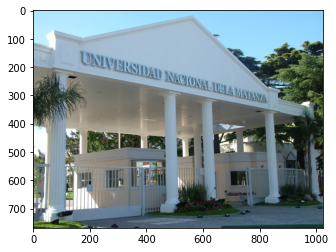

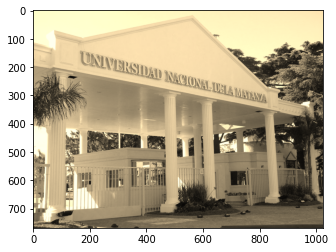

In [ ]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# --------------------------------------------
# Se define la función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# summarize some details about the image 
img_ancho, img_alto  = image.size 

# Se convierte la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_O_cpu = img_O_cpu.astype( numpy.int32() )
img_R_cpu = numpy.empty_like( img_O_cpu)

# Se reservan los 2 vectores en GPU(3 pixeles usa RGB * (tamaño del array))
img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

# GPU - Se copia la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# CPU - Se define la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, int *img_O, int *img_R )
{
  // Se calcula las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  float fRojo = 0.0;
  float fVerde = 0.0;
  float fAzul = 0.0;

  // Se verifica que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {
    // Se calcula el color rojo para el pixel a partir de los componentes.
    fRojo = (float)img_O[(idx+(idy*ancho))*3    ]*0.393;  
    fRojo +=(float)img_O[((idx+(idy*ancho))*3)+1]*0.769;  
    fRojo +=(float)img_O[((idx+(idy*ancho))*3)+2]*0.189;  
    // Componente Rojo del pixel.

    // Se calcula el color verde para el pixel a partir de los componentes.
    fVerde = (float)img_O[(idx+(idy*ancho))*3    ]*0.349;  
    fVerde +=(float)img_O[((idx+(idy*ancho))*3)+1]*0.686;  
    fVerde +=(float)img_O[((idx+(idy*ancho))*3)+2]*0.168;   
    // Componente Verde del pixel.
    
    // Se calcula el color azul para el pixel a partir de los componentes.
    fAzul = (float)img_O[(idx+(idy*ancho))*3    ]*0.272;  
    fAzul +=(float)img_O[((idx+(idy*ancho))*3)+1]*0.534;  
    fAzul +=(float)img_O[((idx+(idy*ancho))*3)+2]*0.131;  
    // Componente Azul del pixel.

    // Se escribe el color del pixel.
    img_R[(idx+(idy*ancho))*3  ] = (int) fRojo;
    img_R[(idx+(idy*ancho))*3+1] = (int) fVerde;
    img_R[(idx+(idy*ancho))*3+2] = (int) fAzul;
  }
}
""") 

# Se muestran los atributos de la imagen y como se ve antes del pseudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Se genera la función kernel.
kernel = module.get_function("kernel_img")

tiempo_img = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img = datetime.now()

kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img = datetime.now() - tiempo_img

# GPU - Se copia el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Se muestra la imagen Original sin el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Se muestra la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

tiempo_total = datetime.now() - tiempo_total

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )

#  Tabla de pasos de ejecucuón del programa


 Procesador | Funciòn | Detalle
------------|---------|----------
CPU      |  wget url_imagen       | Lectura de la direcciòn URL de la imagen (jpg) a procesar.
CPU      | pip install pycuda    | Instala en el cuaderno los driver de CUDA para Python.
CPU      |  matplotlib inline    | Macro de Colab para mostrar imagenes.
CPU      |  import                | Importa los módulos para funcionar.
CPU      |  datetime.now()        | Toma el tiempo actual.
CPU      |  Image.open()          | Abre el archivo de la imagen.
CPU      |  numpy.asarray(imagen) | Convierte el formato comprimido JPG a RAW.
CPU      |  numpy.empty_like(()   | Genera el array destino, que tendrá a la imagen resultado. 
**GPU**  |  cuda.mem_alloc()      | Reserva la memoria para las imagenes en GPU.
**GPU**  |  cuda.memcpy_htod()    | Copio los valores en crudo de las imagenes al GPU.
CPU      |  SourceModule()        | Posee el código del kernel.
CPU      |  module.get_function() | convierte el texto del kernel en funcion de Python.
CPU      |  dim_hilo_x, dim_hilo_y| Calcula las dimensiones para la ejecución de 2D.
**GPU**  |  kernel()              | Ejecuta el kernel en GPU, enviando los parametros.
CPU      |  print()               | Informa los atributos de la imagen.
CPU      | cuda.memcpy_dtoh()     | Copia desde la memoria GPU al CPU.
CPU      |  plt.imshow            | Muestra la imagen original.
CPU      |  plt.imshow            | Muestra la imagen resultado.



---
# Conclusiones

Gracias a la utilización de los múltiples hilos del GPU, se obtiene el resultado casi de manera instantánea, debido a la gran capacidad de manejo de grandes volúmenes de datos. 

---
# Bibliografía


[1] MARKDOWN SYNTAX Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[2] Introducción a Python: [Página Colab](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb) 

[3] Tutorial Point Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[4] 2019, Escribe simple filtros de imágenes con Python: [Página web](https://https://haru-atari.com/blog/30-write-simple-image-filters-in-python)

